# Лабораторная работа №2
рынок: **Китай** <br>
период: **2018 год**

Седунов Илья, <br>
Альперович Вадим, <br>
Славутин Александр, <br>
17ПМИ.

In [68]:
import numpy as np
import pandas as pd
import yfinance as yf
import matplotlib.pyplot as plt
from tqdm import tqdm_notebook
import warnings
import seaborn as sns
from seaborn import set_style
set_style('dark')
warnings.simplefilter('ignore')

In [69]:
df = pd.read_excel('data/china_stocks.xlsx').drop_duplicates(['Symbol'])
symbols = list(df['Symbol'])
print('China ticker symbols = ', len(symbols))

China ticker symbols =  2500


In [10]:
from IPython.display import clear_output
start = "2018-01-01"
end   = "2018-12-31"
stocks = {}

for symbol in tqdm_notebook(symbols):
    stocks[symbol] = yf.download(symbol, start=start, end=end, progress=False)
clear_output()
print('Акции собраны!')

Акции собраны!


In [70]:
print('Исторические данные для актива', symbols[120])
# stocks[symbols[120]].head()

Исторические данные для актива 300139.SZ


In [71]:
def get_descriptive_statistics(frame):
    returns = frame["log_return"]
#     returns = returns[~np.isnan(returns)]
#     print(returns.shape)
    E = returns.mean()
    sigma = returns.std()
    frame['E'] = E
    frame['Sigma'] = sigma
    return frame, E, sigma

def get_return(frame):
    frame['return'] = frame['Close'] / frame['Close'].shift(1)
    frame['log_return'] = np.log(frame['return'])
    return frame

In [72]:
stock_stat = pd.DataFrame(columns=['symbol',  'E', 'Sigma', 'mean_vol', 'mean_return', 'mean_log_return'])

for symbol in tqdm_notebook(symbols):
    stock = get_return(stocks[symbol])
    stock, E, Sigma = get_descriptive_statistics(stock)
    if stock['return'][~np.isnan(stock['return'])].shape[0] < 220:
        continue
#     log_return = stock['log_return']
#     stock['log_return'][~np.isfinite(log_return)] = np.mean(log_return[np.isfinite(log_return)])
    stock_stat.loc[symbol] = [symbol,
                               E,
                               Sigma, 
                               stock['Volume'].mean(), 
                               stock['return'].mean(), 
                               stock['log_return'].mean()]

In [73]:
stock_stat.dropna(inplace=True)
print('Осталось активов после обработки', len(stock_stat))
# stock_stat.head(3)

Осталось активов после обработки 2349


In [74]:
# SSE50 index
sse_components = pd.read_csv('data/SSE50.csv', names=['name', 'industry','symbol'])
sse50 = yf.download('^SSE50', start=start, end=end, progress=False)
sse50 = get_return(sse50)
_, E_sse50, Sigma_sse50 = get_descriptive_statistics(sse50)
# sse50.head(3)

In [75]:
# sse50 components 
sse_stat = pd.DataFrame(columns=['Sigma', 'E', 'names', 'mean_vol', 'mean_log_return', 'industry'])
sse_stocks = {}

for index, row in tqdm_notebook(sse_components.iterrows(), total=len(sse_components)):
    name, industry, symbol = row
    if (name != 'Index' and name != 'Bank of China Limited'):
        symbol = str(symbol) + '.SS'
    sse_stock = yf.download(symbol, start="2018-01-01", end="2018-12-31", progress=False)
    sse_stock = get_return(sse_stock)
#     log_return = sse_stock['log_return']
#     sse_stock['log_return'][~np.isfinite(log_return)] = np.mean(log_return[np.isfinite(log_return)])
    sse_stock, E, s = get_descriptive_statistics(sse_stock)
    mean_vol = sse_stock['Volume'].mean()
    sse_stocks[industry+'/'+name] = sse_stock
        
    sse_stat.loc[index] = [s, E, name, mean_vol, sse_stock['log_return'].mean(), industry]

In [76]:
def get_return_mean_cov(df, sse_components=False): 
    r_matrix = {}
    if sse_components:
        for i in range(len(df)):
            stock_name = df.industry.iloc[i]+'/'+df.names.iloc[i]
            r_matrix[stock_name] = sse_stocks[stock_name]['log_return']
    else:
        for symbol in df['symbol']:
            r_matrix[symbol] = stocks[symbol]['log_return'] 
    r_df = pd.DataFrame(r_matrix)
    return r_df.values, r_df.mean().values, r_df.cov().values

def plot_mean_var_map(df,x='Sigma', y='E', title='Карта активов:σ от E', figsize=(12, 6)):
    ax = df.plot(x=x, y=y, s=np.log(df['mean_vol']**3), 
                          kind='scatter', 
                          figsize=figsize, 
                          edgecolor='black',
                          grid=True)
    plt.xlabel('Sigma', size=15)
    plt.ylabel('E', size=15)
    plt.title(title, size=16)

## 1. Efficient frontier. 
 1. Выбрать на рынке набор из 50 акций. 
 2. Построить эффективный фронт портфелей инвестиций без ограничений на короткие позиции и эффективный фронт с запретом  - коротких позиций. 
 3. Сравнить эффективные фронты и сделать выводы. 
 4. При построении эффективных фронтов вычислить портфели с минимальным риском и отметить их на соответствующем  эффективном фронте. 
 5. Рассмотреть портфель с равными долями вложения капитала и оценить, как далек этот портфель от эффективного фронта. 
 6. Тот же вопрос для индекса рынка.

### 1.1 Выбрать на рынке набор из 50 акций.

In [77]:
selected50 = sse_stat.iloc[:-1]
selected50.head()

,Sigma,E,names,mean_vol,mean_log_return,industry
0,0.023446,-0.000042,Tsinghua Tongfang,1.591310e+07,-0.000042,Other
1,0.027455,-0.002233,China Southern Airlines,9.277587e+07,-0.002233,Airline
2,0.018923,-0.000723,SAIC Motor,1.980929e+07,-0.000723,Automotive
3,0.013761,-0.001078,Shanghai Pudong Development Bank,3.586864e+07,-0.001078,Banking
4,0.012259,-0.000886,China Minsheng Bank,8.009104e+07,-0.000886,Banking


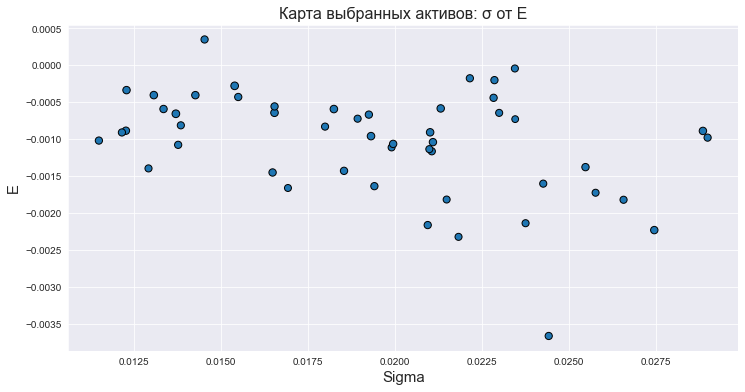

In [78]:
plot_mean_var_map(selected50, title='Карта выбранных активов: σ от E')

### 1.2 Построить эффективный фронт портфелей инвестиций 

In [79]:
from scipy.optimize import minimize

def risk_porfolio(X, cov_matrix):
    return np.sqrt(np.dot(np.dot(X, cov_matrix), X.T))

def optimize_portfolio(risk_porfolio,
                       returns, 
                       cov_matrix, 
                       bounds,
                       N, target_return=None):
    X = np.ones(N)
    X = X / X.sum()
    bounds = bounds * N

    constraints=[]
    constraints.append({'type': 'eq', 'fun': lambda X: np.sum(X) - 1.0})
    if target_return:
        constraints.append({'type': 'eq', 
                            'args': (returns,), 
                            'fun': lambda X, returns: portfolio_return - np.dot(X, returns)})

    return minimize(risk_porfolio, X,
                    args=(cov_matrix), method='SLSQP',
                    constraints=constraints,
                    bounds=bounds).x

 - без ограничений на короткие позиции 

$$ \begin{cases} \sum \sum x_i x_j \sigma_{ij} \rightarrow  min \\ \sum x_i = 1 \end{cases} $$

In [80]:
r_matrix, mean_vec, cov_matrix = get_return_mean_cov(selected50, sse_components=True)

In [81]:
N = 50
psigmas = []
preturns = []
bounds = ((None, None),) 



X_min_risk = optimize_portfolio(risk_porfolio,
                           selected50['E'].values,
                           cov_matrix,
                           bounds, 
                           N)
min_risk = risk_porfolio(X_min_risk, cov_matrix)
min_risk_preturn = np.dot(X_min_risk, selected50['E'].values)
target_range = np.linspace(min_risk_preturn, 0.1, 40)
    
for portfolio_return in tqdm_notebook(target_range):
    X = optimize_portfolio(risk_porfolio,
                           selected50['E'].values,
                           cov_matrix,
                           bounds, 
                           N, 
                           target_return=portfolio_return)
    psigmas.append(risk_porfolio(X, cov_matrix))
    preturns.append(np.dot(X, selected50['E'].values))

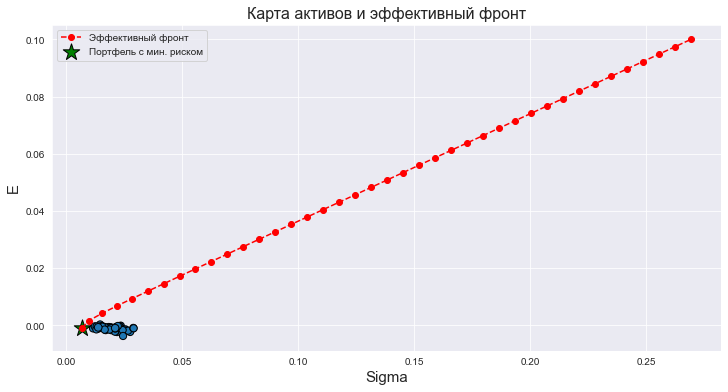

In [82]:
plot_mean_var_map(selected50, title='Карта активов и эффективный фронт')
plt.scatter(min_risk, min_risk_preturn, c='green',
            marker='*', s=300, label='Портфель с мин. риском', edgecolors='black',)
plt.plot(psigmas, preturns, 'ro--', label='Эффективный фронт')
plt.legend()
plt.show()

 -  с запретом  - коротких позиций.
$$ \begin{cases} \sum \sum x_i x_j \sigma_{ij} \rightarrow  min \\ \sum x_i = 1 \\ x_i > 0 \quad \forall i\end{cases} $$

In [83]:
N = 50
psigmas_no_short = []
preturns_no_short = []
bounds = ((0.0, 1.1),) 


X_min_risk_ns = optimize_portfolio(risk_porfolio,
                                   selected50['E'].values,
                                   cov_matrix,
                                   bounds, 
                                   N)
min_risk_ns = risk_porfolio(X_min_risk_ns, cov_matrix)
min_risk_preturn_ns = np.dot(X_min_risk_ns, selected50['E'].values)
target_range = np.linspace(-0.001, 1, 100)


for portfolio_return in tqdm_notebook(target_range):
    X_no_short = optimize_portfolio(risk_porfolio,
                                   selected50['E'].values,
                                   cov_matrix,
                                   bounds, 
                                   N, 
                                   target_return=portfolio_return)
    psigmas_no_short.append(risk_porfolio(X_no_short, cov_matrix))
    preturns_no_short.append(np.dot(X_no_short, selected50['E'].values))

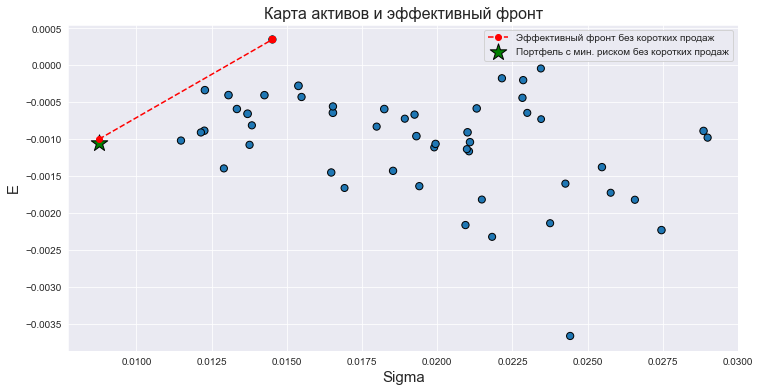

In [84]:
plot_mean_var_map(selected50, title='Карта активов и эффективный фронт')
plt.plot(psigmas_no_short, preturns_no_short, 'ro--', label='Эффективный фронт без коротких продаж')
plt.scatter(min_risk_ns, min_risk_preturn_ns, c='green',
            marker='*', s=300, edgecolors='black',
            label='Портфель с мин. риском без коротких продаж')
plt.legend()
plt.show()

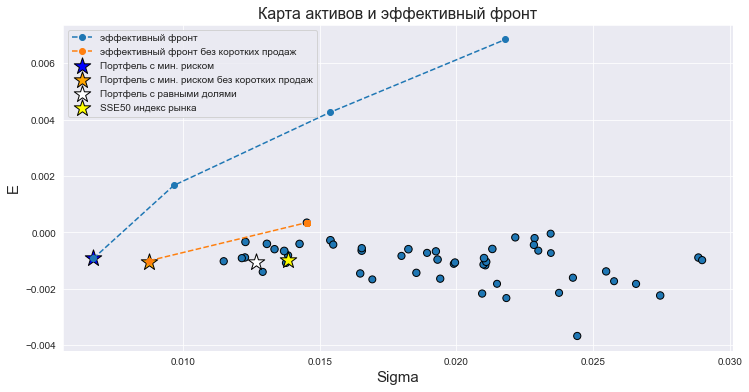

In [85]:
p = 4
plot_mean_var_map(selected50, title='Карта активов и эффективный фронт')
plt.plot(psigmas[:p], preturns[:p], 'o--', label='эффективный фронт')
plt.plot(psigmas_no_short, preturns_no_short, 'o--', label='эффективный фронт без коротких продаж')

plt.scatter(min_risk, min_risk_preturn, c='blue',
            marker='*', s=300, edgecolors='black',
            label='Портфель с мин. риском')

plt.scatter(min_risk_ns, min_risk_preturn_ns, c='orange',
            marker='*', s=300, edgecolors='black',
            label='Портфель с мин. риском без коротких продаж')

risk_pequals = risk_porfolio(np.ones(50) / 50, cov_matrix ) 
return_pequals = np.dot((np.ones(50) / 50),  selected50['E'].values)

plt.scatter(risk_pequals, return_pequals, c='white',
            marker='*', s=300, label='Портфель с равными долями', edgecolors='black')


plt.scatter(Sigma_sse50, E_sse50, c='yellow',
            marker='*', s=300, label='SSE50 индекс рынка', edgecolors='black')

plt.legend()
plt.show()

**Комментарий:** <br>Как и ожидалось эффективный фронт с запрещенными продажами оказался ниже эффективного фронта без ограничений, а портфель с минимальным риском более рисковый практически при равной доходности.

## 2. Portfolio selection problem. 
Требуется построить «хорошие» инвестиционные портфели из 10 активов вместо исходных 50 (или даже всех активов рынка). Предложите способ выбрать 10 активов (из отобранных ранее 50) для формирования портфеля. Сравните эффективные фронты всего набора (50 акций) и выбранного набора активов (10 акций) для двух случаев
 - короткие продажи разрешены,
 - короткие продажи запрещены.

In [86]:
# способ 2: выбираем 10 самых лучших акций по коэффициенту Шарпа
stock_stat['sharp'] = stock_stat['E'] / (stock_stat['Sigma'])
selected10 = stock_stat.sort_values(['sharp'], ascending=[ False]).iloc[:25]

sample_return = { }
for i in tqdm_notebook(range(2000)):
    selected10 = selected10.sample(10)
    r_matrix, mean_vec, cov_matrix = get_return_mean_cov(selected10)
    sample_return[(mean_vec.sum()) / (cov_matrix**2).sum()] = (r_matrix, mean_vec, cov_matrix, selected10)

In [87]:
r_matrix, mean_vec, cov_matrix, selected10 = sample_return[max(sample_return.keys())]
selected10

,symbol,E,Sigma,mean_vol,mean_return,mean_log_return,sharp
300001.SZ,300001.SZ,0.000995,0.023746,5.375081e+06,1.001277,0.000995,0.041885
603288.SS,603288.SS,0.001070,0.025118,3.425374e+06,1.001384,0.001070,0.042582
600436.SS,600436.SS,0.001154,0.027695,5.525580e+06,1.001536,0.001154,0.041683
300684.SZ,300684.SZ,0.002879,0.066310,6.422057e+06,1.004886,0.002879,0.043418
300253.SZ,300253.SZ,0.002496,0.035459,3.917076e+07,1.003131,0.002496,0.070403
603043.SS,603043.SS,0.001359,0.027191,2.691202e+06,1.001729,0.001359,0.049982
002463.SZ,002463.SZ,0.001233,0.029487,3.124009e+07,1.001669,0.001233,0.041821
002607.SZ,002607.SZ,0.002388,0.036970,3.123941e+07,1.003077,0.002388,0.064586
600776.SS,600776.SS,0.001873,0.036444,1.414126e+07,1.002544,0.001873,0.051390
300389.SZ,300389.SZ,0.001127,0.027460,1.517015e+06,1.001503,0.001127,0.041030


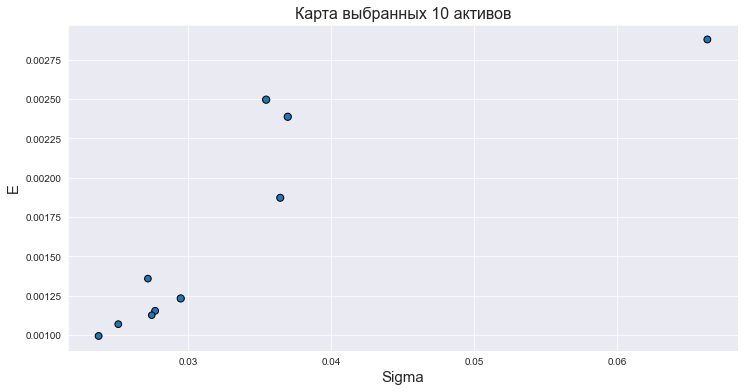

In [88]:
plot_mean_var_map(selected10, title='Карта выбранных 10 активов')

In [89]:
# эффективный фронт 

N = 10
psigmas10 = []
preturns10 = []
bounds = ((None, None),) 


target_range = np.linspace(0, 0.1, 30)

Xs10 = []
# bounds = ((None, None),) 
for portfolio_return in tqdm_notebook(target_range):
    X10 = optimize_portfolio(risk_porfolio,
                            mean_vec,
                           cov_matrix,
                           bounds, 
                           N, 
                           target_return=portfolio_return)
    Xs10.append(X10)
    psigmas10.append(risk_porfolio(X10, cov_matrix))
    preturns10.append(np.dot(X10, mean_vec))

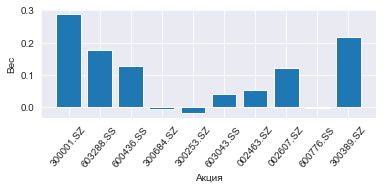

In [90]:
def plot_weights_histogram(weights, data):
    plt.figure(figsize=(6,2))
    try:
        x_values = data['symbol'].values
    except:
        x_values = data['names'].values
    x = np.arange(len(weights))
    plt.xlabel('Акция')
    plt.ylabel('Вес')
    height = weights
    plt.bar(x, height=height)
    plt.xticks(x, x_values, rotation='50')
    plt.grid()
    
plot_weights_histogram(Xs10[0], selected10)

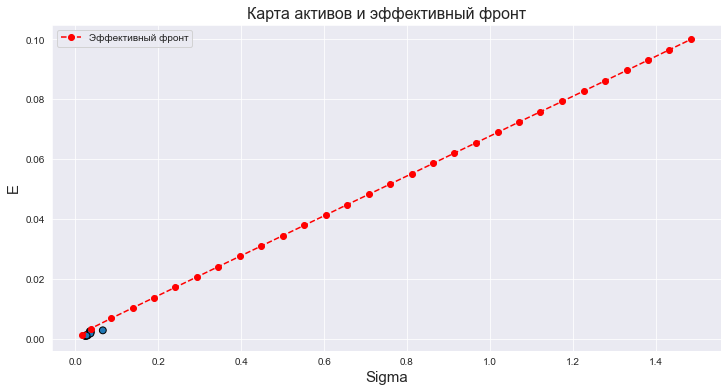

In [91]:
plot_mean_var_map(selected10, title='Карта активов и эффективный фронт')
plt.plot(psigmas10, preturns10, 'ro--', label='Эффективный фронт')
plt.legend()
plt.show()

In [102]:
# эффективный фронт без коротких продаж

N = 10
psigmas10_no_short = []
preturns10_no_short = []
bounds = ((0,1),) 


target_range = np.linspace(0, 0.1, 40)

Xs_no_short10 = []
bounds = ((0, 1),) 
for portfolio_return in tqdm_notebook(target_range):
    X_no_short10 = optimize_portfolio(risk_porfolio,
                                       mean_vec,
                                       cov_matrix,
                                       bounds, 
                                       N, 
                                       target_return=portfolio_return)
    Xs_no_short10.append(X_no_short10)
    psigmas10_no_short.append(risk_porfolio(X_no_short10, cov_matrix))
    preturns10_no_short.append(np.dot(X_no_short10, selected10['E'].values))

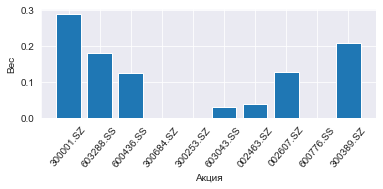

In [103]:
plot_weights_histogram(Xs_no_short10[0], selected10)

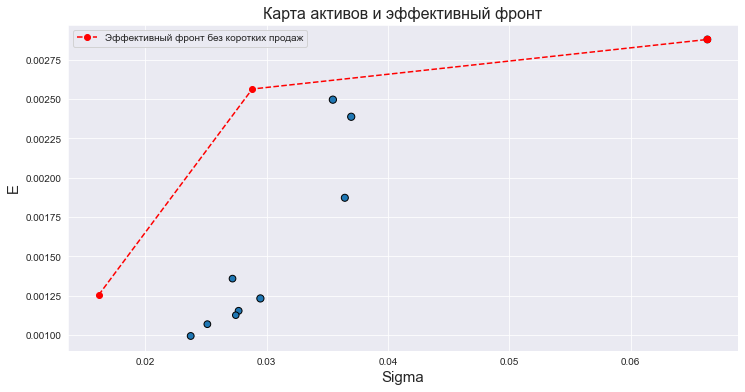

In [104]:
plot_mean_var_map(selected10, title='Карта активов и эффективный фронт')
plt.plot(psigmas10_no_short, preturns10_no_short, 'ro--', label='Эффективный фронт без коротких продаж')
plt.legend()
plt.show()

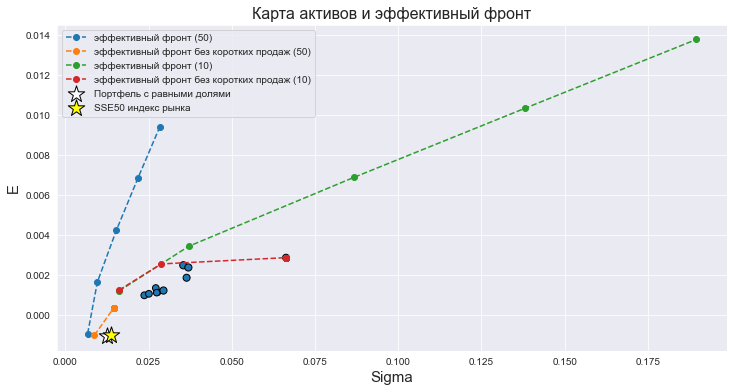

In [105]:
p = 5
plot_mean_var_map(selected10,#.append(selected50),
                  title='Карта активов и эффективный фронт')


plt.plot(psigmas[:p], preturns[:p], 'o--', label='эффективный фронт (50)')
plt.plot(psigmas_no_short, preturns_no_short, 'o--', label='эффективный фронт без коротких продаж (50)')
plt.plot(psigmas10[:p], preturns10[:p], 'o--', label='эффективный фронт (10)')
plt.plot(psigmas10_no_short, preturns10_no_short, 'o--', label='эффективный фронт без коротких продаж (10)')


plt.scatter(risk_pequals, return_pequals, c='white',
            marker='*', s=300, label='Портфель с равными долями', edgecolors='black')

plt.scatter(Sigma_sse50, E_sse50, c='yellow',
            marker='*', s=300, label='SSE50 индекс рынка', edgecolors='black')

plt.legend()
plt.show()

**Комментарий:** <br> В случае разрешенных коротких продаж эффективный фронт на основе 50 является более предпочтительным для инвесторов. Однако, если же короткие позиции запрещены, то эффективный фронт основанный на 10 акций превосходит эфф. фронт для 50 акций с такими же ограничениями.

## 3. Risk aversion. 
Оцените свое отношение к риску и постройте свой личный оптимальный портфель инвестиций из выбранных 50 активов. Дайте характеристику портфеля по составу и долям активов. Оцените VaR доходностей портфеля. Рассмотрите два случая:

 - короткие продажи разрешены,
 - короткие продажи запрещены.

In [166]:
from scipy import stats

def objective_function(X, returns, risk_level, cov_matrix):
    # risk_level is alpha
    return - np.dot(returns, X) + risk_level * risk_porfolio(X, cov_matrix)
    
def optimize_risk_aversion_portfolio(objective_function, returns, cov_matrix, risk_level, bounds, N):
    X = np.ones(N)
    X = X / X.sum()
    bounds = bounds * N
    
    constraints=[]
    constraints.append({'type': 'eq', 'fun': lambda X: np.sum(X) - 1.0})
    
    return minimize(objective_function, X,
                    args=(returns, risk_level, cov_matrix), method='SLSQP',
                    constraints=constraints,
                    bounds=bounds).x
    
def risk_aversion_computing(params_, sse_components=False):
    min_risk, min_risk_preturn, losses = [], [], {}
    N = len(params_['data'])
    E = params_['data']['E'].values
    r_matrix, mean_vec, cov_matrix = get_return_mean_cov(params_['data'], 
                                                         sse_components=sse_components)
    X_min_risks = []
    bounds = ((-1, 1),) if params_['short'] else ((0, 1),)
    for risk_level in params_['risk_levels']:
        X_min_risk = optimize_risk_aversion_portfolio(objective_function, E, cov_matrix, 
                                                      risk_level, bounds, N)
        min_risk.append(risk_porfolio(X_min_risk, cov_matrix))
        min_risk_preturn.append(np.dot(X_min_risk, E))
        losses[risk_level] = - np.dot(r_matrix,X_min_risk)
        X_min_risks.append(X_min_risk)
    return min_risk, min_risk_preturn, losses, X_min_risks

def plot_risk_aversion_method(params_, min_risk_, min_risk_preturn_, short=False):
    plot_mean_var_map(params_['data'], title='Карта активов')
    short_sales_word = 'разрешением' if short else 'запретом'

    for ind, risk_level in enumerate(params_['risk_levels']):
        plt.scatter(min_risk_[ind], min_risk_preturn_[ind],
                marker='*', s=300, label='Портфель с мин. риском с ' + short_sales_word + ' коротких продаж, alpha = ' + str(risk_level), 
                edgecolors='black',)
    plt.legend()
    plt.show()

In [178]:
params_50 = {}
min_risk, min_risk_preturn = [], []
params_50['short'] = True
params_50['data'] = selected50
params_50['risk_levels'] = [0.5, 0.7, 0.95]
losses = {} # вычислим потери как минус лог. доходности

min_risk, min_risk_preturn, losses, X_mins_ = risk_aversion_computing(params_50, sse_components=True)

 - без ограничений на короткие позиции 

$$ \begin{cases} -E(x) + \alpha\sigma(x) \rightarrow  min \\ \sum x_i = 1 \end{cases} $$

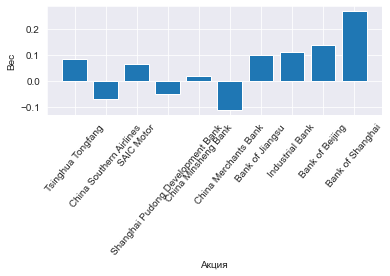

In [180]:
plot_weights_histogram(X_mins_[1][:10], selected50.head(10))

**Коментарий:** Если взглянуть на первые 10 активов в портфеле, можно заметить, что 7 позиций из 10 занимают банки, так как банки являются наименее рисковыми активами.

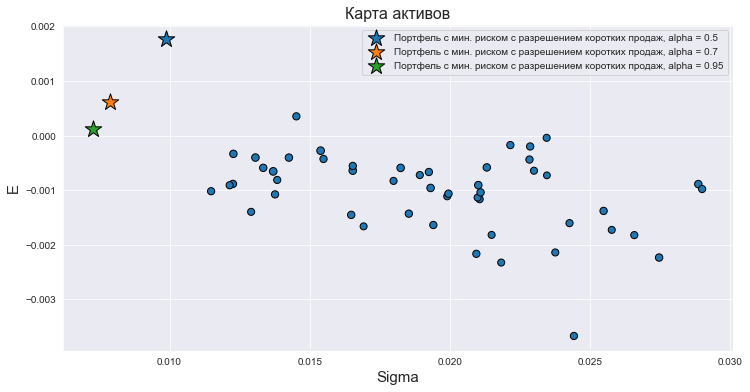

In [168]:
plot_risk_aversion_method(params_50, min_risk, min_risk_preturn, True)

**Комментарий:** были построены три портфели с различными отношениями к риску, очевидно, что портфель с более строгим отношением к риску (0.95) с наибольшим успехом деверсифицирует риск.

Рассчитаем **VaR** 

In [169]:

from scipy.stats import norm

def VaR_info(risk_levels_, losses_):
    confidence_lvl = [0.9, 0.95, 0.99]
    VaR = {}
    for risk_level in risk_levels_:
        print('VaR характеристика для портфеля с уровнем риска %s:' % risk_level)
        for clvl in confidence_lvl:
            loss = losses_[risk_level]
            loss = loss[np.isfinite(loss)]
            VaR[clvl] = np.quantile(loss, clvl)
            print(' - Потери не превысят %.4f с %.2f%s уверенностью.' % (np.round(VaR[clvl],4), clvl, '%'))
            
VaR_info(params_50['risk_levels'], losses)

VaR характеристика для портфеля с уровнем риска 0.5:
 - Потери не превысят 0.0112 с 0.90% уверенностью.
 - Потери не превысят 0.0155 с 0.95% уверенностью.
 - Потери не превысят 0.0226 с 0.99% уверенностью.
VaR характеристика для портфеля с уровнем риска 0.7:
 - Потери не превысят 0.0085 с 0.90% уверенностью.
 - Потери не превысят 0.0132 с 0.95% уверенностью.
 - Потери не превысят 0.0219 с 0.99% уверенностью.
VaR характеристика для портфеля с уровнем риска 0.95:
 - Потери не превысят 0.0078 с 0.90% уверенностью.
 - Потери не превысят 0.0124 с 0.95% уверенностью.
 - Потери не превысят 0.0224 с 0.99% уверенностью.


**Комментарии**: Из рассчётов **VaR** можно сделать вывод, что первый портфель гарантирует не более 2.5%.

 -  с запретом  - коротких позиций.
$$ \begin{cases}  -E(x) + \alpha\sigma(x) \rightarrow  min \\ \sum x_i = 1 \\ x_i > 0 \quad \forall i\end{cases} $$

In [181]:
params_50_no_short = params_50
params_50_no_short['short'] = False
losses_no_short = {} # вычислим потери как минус лог. доходности
min_risk_no_short, min_risk_preturn_no_short = [], []

min_risk_no_short, min_risk_preturn_no_short, losses_no_short, X_mins_50_ns = risk_aversion_computing(params_50_no_short, 
                                                                                        sse_components=True)

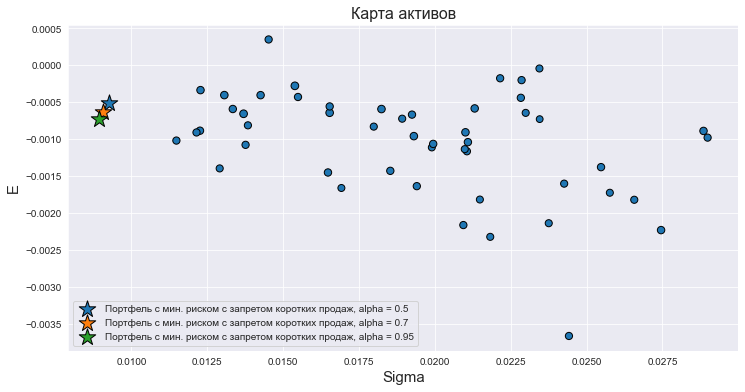

In [171]:
plot_risk_aversion_method(params_50_no_short, min_risk_no_short, min_risk_preturn_no_short, short=False)

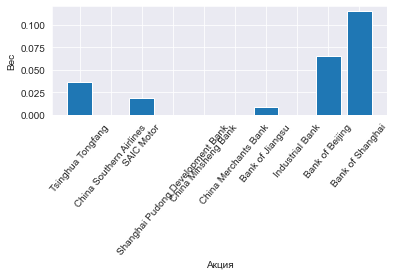

In [182]:
plot_weights_histogram(X_mins_50_ns[1][:10], selected50.head(10))

**Комментарий:** построив портфель с запретом коротких продаж можно заметить, что среди банков появились отчётливые "лидеры", Национальный банк Шанхая имеет коэффициент 0.14 (кол-во активов 50). 

In [189]:
VaR_info(params_50_no_short['risk_levels'], losses_no_short)

VaR характеристика для портфеля с уровнем риска 0.5:
 - Потери не превысят 0.0113 с 0.90% уверенностью.
 - Потери не превысят 0.0147 с 0.95% уверенностью.
 - Потери не превысят 0.0312 с 0.99% уверенностью.
VaR характеристика для портфеля с уровнем риска 0.7:
 - Потери не превысят 0.0112 с 0.90% уверенностью.
 - Потери не превысят 0.0146 с 0.95% уверенностью.
 - Потери не превысят 0.0307 с 0.99% уверенностью.
VaR характеристика для портфеля с уровнем риска 0.95:
 - Потери не превысят 0.0108 с 0.90% уверенностью.
 - Потери не превысят 0.0145 с 0.95% уверенностью.
 - Потери не превысят 0.0302 с 0.99% уверенностью.


## 4. Risk aversion and Portfolio selection.
Используя выбранное в п.3 отношение к риску постройте оптимальный портфель из 10 активов (вместо 50, см. п.2). Дайте характеристику этого портфеля по составу активов и долям инвестиций. Сравните с портфелем п.3. Оцените VaR доходностей портфеля. Рассмотрите два случая:

  - короткие продажи разрешены,
  - короткие продажи запрещены.

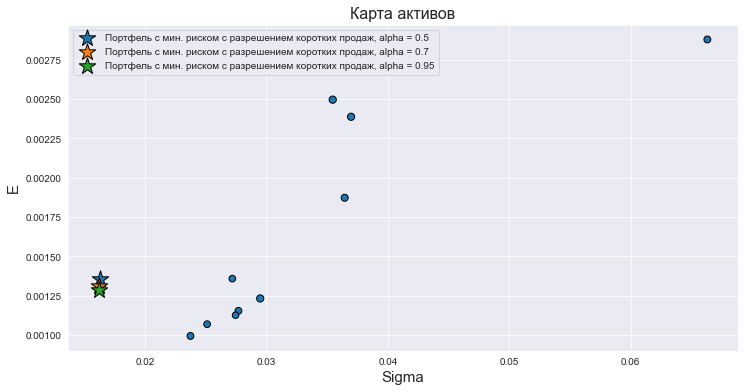

In [196]:
params_10 = params_50
params_10['short'] = True
params_10['data'] = selected10
losses, min_risk, min_risk_preturn = {}, [], []

min_risk, min_risk_preturn, losses_10, X_mins_10 = risk_aversion_computing(params_10)
plot_risk_aversion_method(params_10, min_risk, min_risk_preturn, short=True)

In [202]:
selected10['symbol'] = ['Qingdao TGOOD Electric', 
                       'Foshan Haitian Flavouring & Food', 
                       'Zhangzhou Pientzehuang Pharmaceuticl',
                       'Jones Tech PLC',
                       'Winning Health Technology Group Co Ltd',
                       'Guangzhou Restaurant Group Co Ltd',
                       'WUS Printed Circuit (Kunshan) Co.,Ltd.',
                       'Offcn Education Technology Co Ltd',
                       'Eastern Communications Ord Shs A',
                       'Shenzhen Absen Optoelectronic Co Ltd']

In [204]:
X_mins_10[0]

array([0.23950938, 0.16136699, 0.12606307, 0.00609425, 0.0270302 ,
       0.0457961 , 0.026875  , 0.15083701, 0.02047583, 0.19595216])

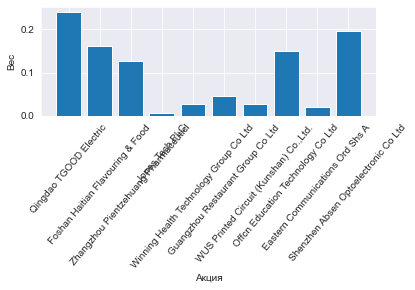

In [203]:
plot_weights_histogram(X_mins_10[0], selected10)

**Комментарий:** 50 акций в п.1 были взяты из индекса SSE50, 10 же акций были отобраны из более широкой подвыборки. Видно, что в данном портфеле бОльшие коэффициенты имеют компании связанные с электроникой: Qingdao TGOOD Electric и Shenzhen Absen Optoelectronic Co Ltd (0.24 и 0.20).

In [192]:
VaR_info(params_10['risk_levels'], losses_10)

VaR характеристика для портфеля с уровнем риска 0.5:
 - Потери не превысят 0.0170 с 0.90% уверенностью.
 - Потери не превысят 0.0259 с 0.95% уверенностью.
 - Потери не превысят 0.0440 с 0.99% уверенностью.
VaR характеристика для портфеля с уровнем риска 0.7:
 - Потери не превысят 0.0169 с 0.90% уверенностью.
 - Потери не превысят 0.0257 с 0.95% уверенностью.
 - Потери не превысят 0.0437 с 0.99% уверенностью.
VaR характеристика для портфеля с уровнем риска 0.95:
 - Потери не превысят 0.0170 с 0.90% уверенностью.
 - Потери не превысят 0.0255 с 0.95% уверенностью.
 - Потери не превысят 0.0436 с 0.99% уверенностью.


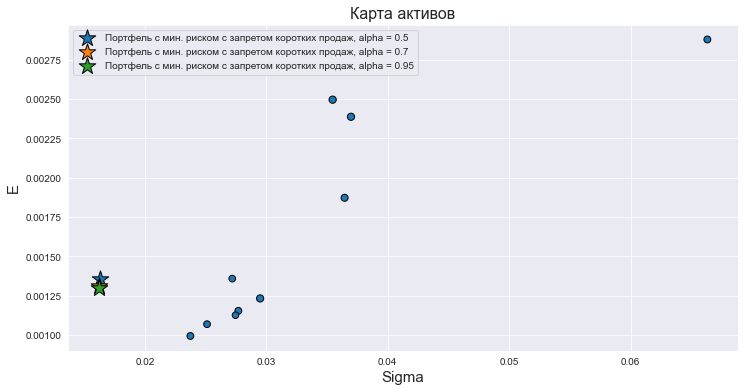

In [194]:
params_10_no_short = params_10
params_10_no_short['short'] = False
losses_ns, min_risk_ns, min_risk_preturn_ns = {}, [], []
min_risk_ns, min_risk_preturn_ns, losses_ns, X_mins_10_ns = risk_aversion_computing(params_10_no_short)
plot_risk_aversion_method(params_10_no_short, min_risk_ns, min_risk_preturn_ns, short=False)

In [195]:
VaR_info(params_10_no_short['risk_levels'], losses_ns)

VaR характеристика для портфеля с уровнем риска 0.5:
 - Потери не превысят 0.0169 с 0.90% уверенностью.
 - Потери не превысят 0.0260 с 0.95% уверенностью.
 - Потери не превысят 0.0438 с 0.99% уверенностью.
VaR характеристика для портфеля с уровнем риска 0.7:
 - Потери не превысят 0.0168 с 0.90% уверенностью.
 - Потери не превысят 0.0257 с 0.95% уверенностью.
 - Потери не превысят 0.0436 с 0.99% уверенностью.
VaR характеристика для портфеля с уровнем риска 0.95:
 - Потери не превысят 0.0171 с 0.90% уверенностью.
 - Потери не превысят 0.0256 с 0.95% уверенностью.
 - Потери не превысят 0.0439 с 0.99% уверенностью.


## 5. Markowitz-Tobin model. 
Рассмотрите набор активов, отобранных в п.2 (10 активов). Выберете безрисковый актив (можно виртуальный). Постройте рыночный (оптимальный) портфель. Сделайте анализ долей активов рыночного портфеля. Оцените VaR доходностей портфеля. Рассмотрите два случая:

 - короткие продажи разрешены,
 - короткие продажи запрещены.


In [2275]:
risk_free = selected10.sort_values(['Sigma']).head(1)
risk_free

,symbol,E,Sigma,mean_vol,mean_return,mean_log_return,sharp
300429.SZ,300429.SZ,0.001129,0.022912,3.102795e+06,1.001391,0.001129,0.049283


In [2276]:
from scipy import optimize
def objective_function(x, cov_matix, mean_vector, risk_free_mean):
    f = float(-(x.dot(mean_vector) - risk_free_mean) / np.sqrt(np.dot(np.dot(x, cov_matrix), x.T)))
    return f


def optimal_portfolio_sharp_ratio(profits, risk_free_mean, N, cov_matrix,returns,bounds):
    X = np.ones(N)
    X = X / X.sum()
    bounds = bounds * N
    constraints=[]
    constraints.append({'type': 'eq', 'fun': lambda X: np.sum(X) - 1.0})
    minimize = optimize.minimize(objective_function, X,
                    args=(cov_matrix, returns, risk_free_mean,), method='SLSQP',
                    constraints=constraints,
                    bounds=bounds).x
    return minimize

def optimal_portfolio_computing(data,risk_free_asset, allow_short = False):
    results = {}
    risk_free_mean = risk_free_asset['E'].values[0]
    N = len(data)
    r_matrix, _, cov_matrix = get_return_mean_cov(data)
    E = data['E'].values
    bounds = ((-1, 1),) if allow_short else ((0, 1),)
    optim_portfolio_weights =  optimal_portfolio_sharp_ratio(selected10,risk_free_mean,N,cov_matrix,E, bounds)
    results['optim_weights'] = optim_portfolio_weights
    results['best_sharp_sigma'] = risk_porfolio(optim_portfolio_weights, cov_matrix)
    results['best_sharp_return'] = np.dot(optim_portfolio_weights, E)
    results['losses'] = -np.dot(r_matrix, optim_portfolio_weights)
    return results
    
def plot_optimal_sharp_ratio_portfolio_method(data, best_sharp_sigma, best_sharp_return, short=False):
    plot_mean_var_map(data, title='Карта активов')
    short_sales_word = 'разрешением' if short else 'запретом'
    plt.scatter(best_sharp_sigma, best_sharp_return,
                marker='*', s=300, 
                label='Портфель максимальный по индексу шарпу с ' + short_sales_word + ' коротких продаж', 
                edgecolors='red')
    plt.legend()
    plt.show()

 - без ограничений на короткие позиции 

$$ \begin{cases} \frac{E(x) - E_{free}}{\sigma(x)} \rightarrow  max \\ \sum x_i = 1 \end{cases} $$

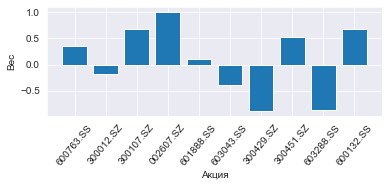

In [2277]:
short_results = optimal_portfolio_computing(selected10, risk_free, allow_short=True)
plot_weights_histogram(short_results['optim_weights'], selected10)

 -  с запретом  - коротких позиций.

$$ \begin{cases} \frac{E(x) - E_{free}}{\sigma(x)} \rightarrow  max \\ \sum x_i = 1  \\ x_i > 0 \quad \forall x_i\end{cases} $$

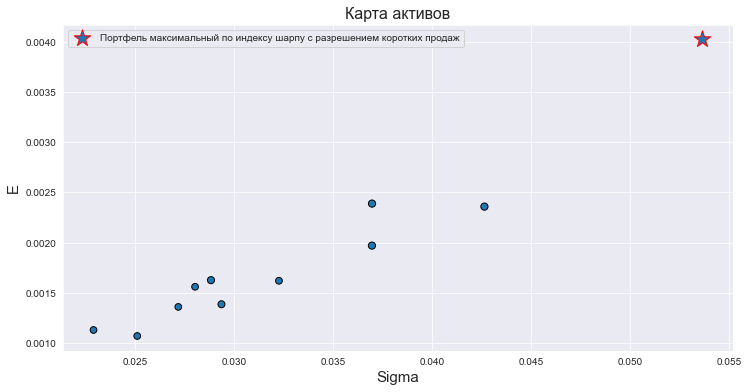

In [2278]:
plot_optimal_sharp_ratio_portfolio_method(selected10, 
                                          short_results['best_sharp_sigma'],
                                          short_results['best_sharp_return'], 
                                          short=True)

In [2279]:
long_results = optimal_portfolio_computing(selected10, risk_free, allow_short=False)

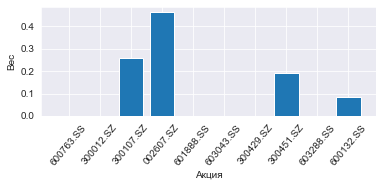

In [2280]:
plot_weights_histogram(long_results['optim_weights'], selected10)

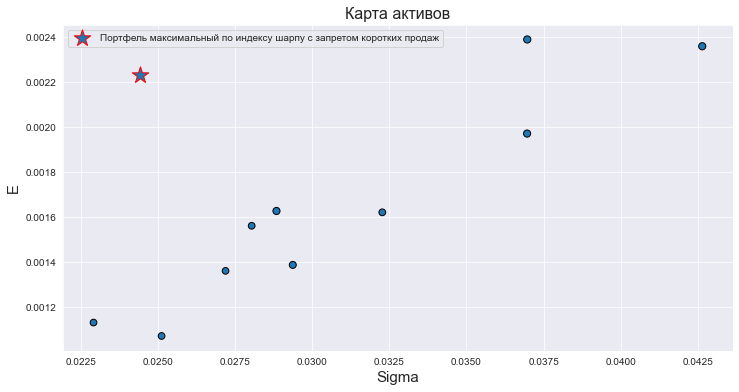

In [2281]:
plot_optimal_sharp_ratio_portfolio_method(selected10, 
                                          long_results['best_sharp_sigma'],
                                          long_results['best_sharp_return'], 
                                          short=False)

In [2282]:
def VaR_info(losses):
    confidence_lvl = [0.9, 0.95, 0.99]
    VaR = {}
    for clvl in confidence_lvl:
        loss = losses[np.isfinite(losses)]
        VaR[clvl] = np.quantile(loss, clvl)
        print(' - Потери не превысят %.4f с %.2f%s уверенностью.' % (VaR[clvl], clvl, '%'))

In [2283]:
print('Короткие продажи разрешены')
VaR_info(short_results['losses'])

Короткие продажи разрешены
 - Потери не превысят 0.0656 с 0.90% уверенностью.
 - Потери не превысят 0.0829 с 0.95% уверенностью.
 - Потери не превысят 0.1328 с 0.99% уверенностью.


In [2284]:
print('Короткие продажи запрещены')
VaR_info(long_results['losses'])

Короткие продажи запрещены
 - Потери не превысят 0.0273 с 0.90% уверенностью.
 - Потери не превысят 0.0346 с 0.95% уверенностью.
 - Потери не превысят 0.0722 с 0.99% уверенностью.


## 6. Бонус. Индекс рынка.

Разберитесь, как составляется портфель индекса (определите веса, с которыми активы входят в индекс). Дайте характеристику индекса (гистограмма, распределение, выбросы). На основе метода главных компонент предложите свою модель индекса рынка. Сравните ваш индекс с индексом рынка.

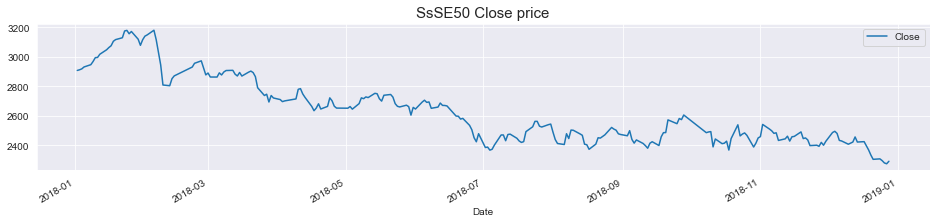

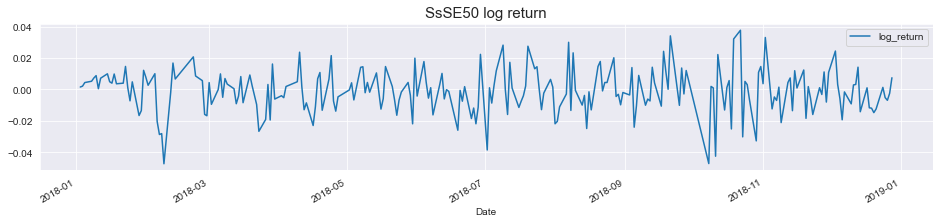

In [2297]:
sse50.plot(y=['Close'], grid=True, figsize=(16,3))
plt.title('SsSE50 Close price', size=15)
sse50.plot(y='log_return', grid=True, figsize=(16,3))
plt.title('SsSE50 log return', size=15)
pass

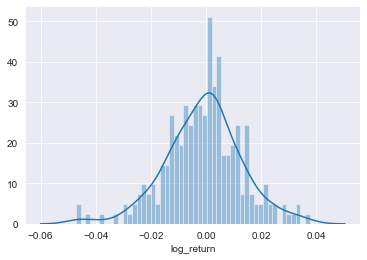

In [2298]:
import seaborn as sns               
plt.grid()
sns.distplot(sse50['log_return'], bins=50)
pass

In [2509]:
from sklearn import decomposition
pca = decomposition.PCA(n_components=4)
r_matrix, mean_vec, cov_matrix = get_return_mean_cov(selected50, sse_components=True)
df =  pd.DataFrame(r_matrix)
df = df.dropna()
r_matrix = df.values
pca.fit(r_matrix)
pca_matrix = pca.transform(r_matrix)

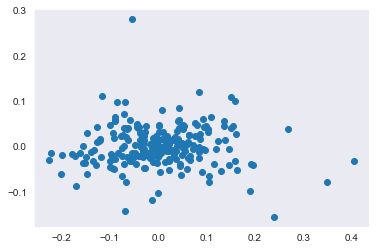

In [2510]:
plt.scatter(pca_matrix[:,0], pca_matrix[:,1])
pass

In [2511]:
sum(pca.explained_variance_ratio_[:10])

0.627024455449731

In [2519]:
i = 0
weights = pca.components_
Xpca = weights[i] / sum(weights[i])
Xpca.sum()

0.9999999999999999

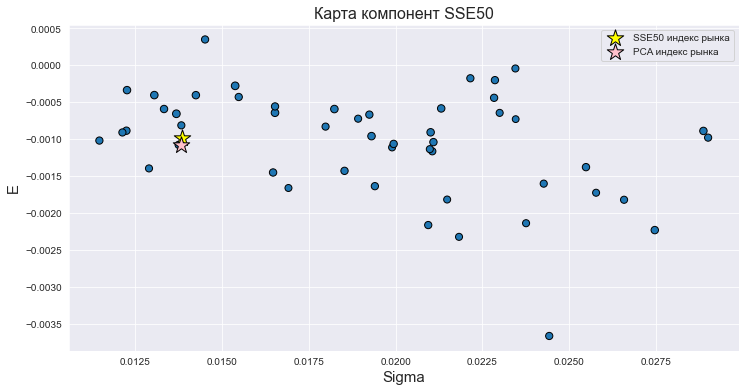

In [2520]:
plot_mean_var_map(selected50, title='Карта компонент SSE50')
plt.scatter(Sigma_sse50, E_sse50, c='yellow',
            marker='*', s=300, label='SSE50 индекс рынка', edgecolors='black')
pca_index_risk = risk_porfolio(Xpca, cov_matrix)
pca_index_return = np.dot(Xpca, mean_vec)
plt.scatter(pca_index_risk, pca_index_return, c='pink',
            marker='*', s=300, label='PCA индекс рынка', edgecolors='black')
plt.legend()
plt.show()

In [2521]:
sse_losses = - sse50['log_return']
VaR_info(sse_losses)

 - Потери не превысят 0.0182 с 0.90% уверенностью.
 - Потери не превысят 0.0239 с 0.95% уверенностью.
 - Потери не превысят 0.0408 с 0.99% уверенностью.


In [2522]:
for i in range(3):
    Xpca = weights[i] / sum(weights[i])
    Xpca.sum()
    losses = -np.dot(r_matrix , Xpca)
    print('Component ', i+1)
    VaR_info(losses)

Component  1
 - Потери не превысят 0.0167 с 0.90% уверенностью.
 - Потери не превысят 0.0232 с 0.95% уверенностью.
 - Потери не превысят 0.0392 с 0.99% уверенностью.
Component  2
 - Потери не превысят 0.0762 с 0.90% уверенностью.
 - Потери не превысят 0.1017 с 0.95% уверенностью.
 - Потери не превысят 0.1833 с 0.99% уверенностью.
Component  3
 - Потери не превысят 0.0690 с 0.90% уверенностью.
 - Потери не превысят 0.0930 с 0.95% уверенностью.
 - Потери не превысят 0.1695 с 0.99% уверенностью.
